# myAOAnet

In [2]:
import os
from os.path import join
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, accuracy_score
%matplotlib inline

## IQ data visualization

In [3]:
iq_data0 = pd.read_csv(join('data_1606', 'iq_example', 'log.csv'), sep=',', header=0)

In [13]:
iq_data = iq_data0.drop(iq_data0.columns[[index for index in range(11)]], axis = 1, inplace = False)
iq_data.shape

(1, 262144)

In [15]:
iq_arr = iq_data.to_numpy().reshape(32768, 4, 2)

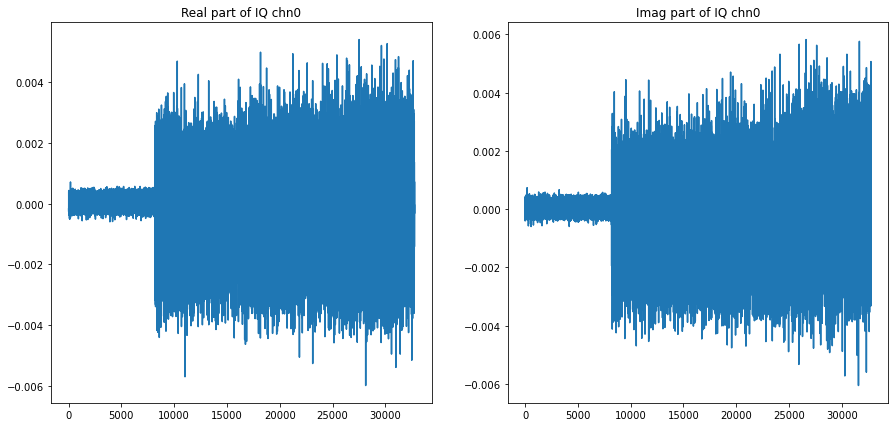

In [26]:
fig0 ,ax0 = plt.subplots(1, 2,figsize=(15,7))
ax0[0].plot(iq_arr[:, 0, 0])
ax0[0].set_title("Real part of IQ chn0")
ax0[1].plot(iq_arr[:, 0, 1])
ax0[1].set_title("Imag part of IQ chn0")
plt.show()

## R-AOA Dataframe

In [4]:
data_dir = 'data_1606'
aoa_dict = {}
#fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data5', 'field.data6', 'field.data7', 'field.data10', 'field.data11', 'field.data15']
fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
              'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
              'field.data20', 'field.data21', 'field.data22', 'field.data23', \
              'field.data30', 'field.data31']

for filename in os.listdir(data_dir):
    if filename.startswith("deg_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[- float(filename[5:-4])] = aoa_Rjk
    elif filename.startswith("deg_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        aoa_dict[float(filename[4:-4])] = aoa_Rjk

In [5]:
num_fields = aoa_dict[0].shape[1]
aoa_dict[0].head(50)

,field.data0,field.data1,field.data2,field.data3,field.data4,field.data5,field.data6,field.data7,field.data10,field.data11,field.data12,field.data13,field.data14,field.data15,field.data20,field.data21,field.data22,field.data23,field.data30,field.data31
0,7.666858e-08,0.0,2.870847e-08,-4.286403e-09,-4.063577e-08,-3.996029e-08,5.745779e-09,-9.190084e-08,0.000004,0.0,-1.089253e-07,-1.703348e-07,1.805027e-08,-3.614795e-07,0.000005,0.0,5.031552e-07,5.018484e-07,0.000005,0.0
1,7.531266e-08,0.0,3.245228e-08,-3.916736e-10,-4.040302e-08,-3.290519e-08,8.592314e-09,-8.882998e-08,0.000004,0.0,-1.271434e-07,-1.307816e-07,5.724483e-08,-3.316083e-07,0.000005,0.0,4.963708e-07,5.642001e-07,0.000005,0.0
2,7.588948e-08,0.0,3.180056e-08,5.191419e-09,-4.132120e-08,-3.589397e-08,4.872057e-09,-9.745519e-08,0.000004,0.0,-1.400175e-07,-1.255275e-07,6.210496e-08,-4.016582e-07,0.000005,0.0,4.443870e-07,6.074567e-07,0.000005,0.0
3,7.457187e-08,0.0,3.099723e-08,-3.193643e-10,-3.700229e-08,-3.373279e-08,1.785910e-09,-8.843575e-08,0.000004,0.0,-1.321670e-07,-1.303623e-07,7.287748e-08,-3.352868e-07,0.000005,0.0,4.859778e-07,4.976154e-07,0.000005,0.0
4,7.577018e-08,0.0,2.757032e-08,-1.282692e-09,-4.205080e-08,-3.180738e-08,5.389584e-09,-9.226090e-08,0.000004,0.0,-9.666718e-08,-1.173304e-07,7.646621e-08,-3.734494e-07,0.000005,0.0,4.574219e-07,5.809664e-07,0.000005,0.0
5,7.528805e-08,0.0,3.513028e-08,-6.089565e-11,-4.178012e-08,-3.318065e-08,1.003521e-08,-9.472239e-08,0.000004,0.0,-1.230802e-07,-1.437402e-07,3.939213e-08,-3.631214e-07,0.000005,0.0,5.217113e-07,5.123710e-07,0.000005,0.0
6,7.575626e-08,0.0,3.804680e-08,5.229464e-09,-4.279267e-08,-3.260863e-08,8.854135e-09,-9.949872e-08,0.000004,0.0,-1.389792e-07,-1.128212e-07,5.615719e-08,-3.984154e-07,0.000005,0.0,4.080420e-07,5.483967e-07,0.000005,0.0
7,7.580216e-08,0.0,2.718681e-08,-3.887301e-09,-3.904420e-08,-3.563963e-08,2.758547e-09,-9.627834e-08,0.000004,0.0,-1.209765e-07,-1.443218e-07,7.443288e-08,-3.504103e-07,0.000005,0.0,4.786470e-07,5.574987e-07,0.000005,0.0
8,7.426785e-08,0.0,3.202805e-08,1.522963e-09,-4.034196e-08,-3.221040e-08,3.395303e-09,-9.191432e-08,0.000004,0.0,-1.020383e-07,-1.174796e-07,6.139486e-08,-3.939927e-07,0.000005,0.0,5.209081e-07,5.165060e-07,0.000005,0.0
9,7.544370e-08,0.0,3.095279e-08,-1.482771e-09,-4.216148e-08,-3.394742e-08,7.034481e-09,-9.015962e-08,0.000004,0.0,-9.089888e-08,-1.660830e-07,6.404755e-08,-3.710307e-07,0.000005,0.0,4.453267e-07,5.382586e-07,0.000005,0.0


In [6]:
#Degree to Radian
for key in aoa_dict.keys():
    aoa_dict[key]['theta'] = key * math.pi / 180

# Show detection of LoRa beacon when Rjk is significant
field_thres = 1e-04

for key in aoa_dict.keys():
    print("%s shape of signal-presenting snapshots = %.01f" % (str(aoa_dict[key][abs(aoa_dict[key]['field.data2']) >= field_thres].shape), key))

(226, 21) shape of signal-presenting snapshots = 0.0
(248, 21) shape of signal-presenting snapshots = 60.0
(195, 21) shape of signal-presenting snapshots = -50.0
(238, 21) shape of signal-presenting snapshots = -60.0
(182, 21) shape of signal-presenting snapshots = -40.0
(203, 21) shape of signal-presenting snapshots = 20.0
(225, 21) shape of signal-presenting snapshots = 70.0
(214, 21) shape of signal-presenting snapshots = 40.0
(186, 21) shape of signal-presenting snapshots = 30.0
(270, 21) shape of signal-presenting snapshots = -30.0
(209, 21) shape of signal-presenting snapshots = -70.0
(222, 21) shape of signal-presenting snapshots = -20.0
(255, 21) shape of signal-presenting snapshots = 10.0
(259, 21) shape of signal-presenting snapshots = -10.0
(233, 21) shape of signal-presenting snapshots = 50.0


/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Differentiate R of LoRa signal or noise
aoa_sig, aoa_noi = {}, {}
sig_index_lst = {}

for key in aoa_dict.keys():
    aoa_sig[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data2']) < field_thres].index)
    aoa_noi[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data2']) >= field_thres].index)
    
    sig_index_lst[key] = (aoa_dict[key][abs(aoa_dict[key]['field.data2']) >= field_thres].index)
    
sig_index_lst[0]

Int64Index([ 19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
            ...
            718, 719, 720, 721, 722, 723, 724, 725, 726, 727],
           dtype='int64', length=226)

In [8]:
# Xaoa = aoa_sig <-> theta[Rad]
Xaoa = pd.concat([aoa_sig[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
idx = pd.IndexSlice

In [9]:
print(Xaoa.shape)
Xaoa.loc[idx[[-10, 0, 30, 70], :], :]
Xaoa

(3365, 21)


field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         0          0.000046          0.0     0.002728     0.000348   
            1          0.000032          0.0     0.002230     0.000289   
            2          0.000008          0.0     0.000627     0.000079   
            27         0.000004          0.0     0.000310     0.000150   
            28         0.000120          0.0    -0.000454    -0.003152   
...                         ...          ...          ...          ...   
 70         707        0.002506          0.0     0.003383     0.023918   
            708        0.002359          0.0     0.003174     0.022460   
            709        0.001897          0.0     0.002347     0.017940   
            710        0.001451          0.0     0.001547     0.013673   
            711        0.000982          0.0     0.000807     0.009173   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         0          0.001615    -0.000416     0.001171    -0.000044   
            1          0.001354    -0.000339     0.001016    -0.000039   
            2          0.000384    -0.000098     0.000293    -0.000017   
            27         0.000223     0.000034     0.000113     0.000085   
            28        -0.000799    -0.001858     0.000271    -0.001878   
...                         ...          ...          ...          ...   
 70         707       -0.016969     0.003560     0.009624    -0.030561   
            708       -0.016128     0.003234     0.009060    -0.029390   
            709       -0.013109     0.002452     0.008144    -0.025374   
            710       -0.010135     0.001830     0.006969    -0.020548   
            711       -0.006896     0.001067     0.005356    -0.014184   

                    field.data10  field.data11  ...  field.data13  \
Series name Row ID                              ...                 
-70         0           0.165659           0.0  ...     -0.037592   
            1           0.161718           0.0  ...     -0.037243   
            2           0.050502           0.0  ...     -0.011764   
            27          0.028097           0.0  ...     -0.005342   
            28          0.165926           0.0  ...     -0.029510   
...                          ...           ...  ...           ...   
 70         707         0.233392           0.0  ...      0.166462   
            708         0.218569           0.0  ...      0.157591   
            709         0.172999           0.0  ...      0.126773   
            710         0.130789           0.0  ...      0.097287   
            711         0.086527           0.0  ...      0.065134   

                    field.data14  field.data15  field.data20  field.data21  \
Series name Row ID                                                           
-70         0           0.069720     -0.011793      0.061505           0.0   
            1           0.072078     -0.012540      0.062923           0.0   
            2           0.023049     -0.004381      0.020062           0.0   
            27          0.011273      0.002239      0.011953           0.0   
            28          0.082327      0.023186      0.068399           0.0   
...                          ...           ...           ...           ...   
 70         707        -0.278442     -0.132870      0.120211           0.0   
            708        -0.267317     -0.125657      0.114910           0.0   
            709        -0.229677     -0.108304      0.093950           0.0   
            710        -0.186047     -0.087480      0.073229           0.0   
            711        -0.127907     -0.061592      0.049657           0.0   

                    field.data22  field.data23  field.data30  field.data31  \
Series name Row ID                                                           
-70         0           0

### MUSIC

In [10]:
# Notice Noisy Rosbags do not contain 'kerberos/doa_results'
data_dir = 'data_1606'
music_dict = {}

for filename in os.listdir(data_dir):
    if filename.startswith("music_deg_m") and filename.endswith(".csv"):
        music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        music_deg.rename(columns = {'field.data': 'music'}, inplace=True)
        music_series = music_deg['music']
        music_dict[- float(filename[11:-4])] = music_series
    elif filename.startswith("music_deg_") and filename.endswith(".csv"):
        music_deg = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        music_deg.rename(columns = {'field.data': 'music'}, inplace=True)
        music_series = music_deg['music']
        music_dict[float(filename[10:-4])] = music_series

In [11]:
for key in music_dict.keys():
    music_dict[key] = music_dict[key][sig_index_lst[key]]

In [12]:
# Add MUSIC_results as 22nd column
Xmusic = pd.concat([music_dict[rad] for rad in range(-70, 80, 10)], keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
Xaoa_music = pd.concat([Xaoa, Xmusic], axis=1)
Xmusic

Series name  Row ID
-70          0           2.0
             1           2.0
             2           2.0
             27        359.0
             28        359.0
                       ...  
 70          707       331.0
             708       331.0
             709       331.0
             710       331.0
             711       331.0
Name: music, Length: 3365, dtype: float64

In [14]:
Xaoa_music.to_csv(join(data_dir, 'df_collection', 'LOS_MUSIC.csv'), index=True, header=True)

## Create Origin-Noisy-MUSIC dataset

In [13]:
#field_thres = 1e-04

def create_dataset(data_dir, sigma, Xmusic=Xmusic):
    aoa_dict = {}
    #fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data5', 'field.data6', 'field.data7', 'field.data10', 'field.data11', 'field.data15']
    fields_lst = ['field.data0', 'field.data1', 'field.data2', 'field.data3', 'field.data4', 'field.data5', 'field.data6', 'field.data7', \
                  'field.data10', 'field.data11', 'field.data12', 'field.data13', 'field.data14', 'field.data15', \
                  'field.data20', 'field.data21', 'field.data22', 'field.data23', \
                  'field.data30', 'field.data31']

    for filename in os.listdir(data_dir):
        if filename.startswith("deg_m") and filename.endswith("_" + sigma + ".csv"):
            aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[- float(filename[5:-9])] = aoa_Rjk
        elif filename.startswith("deg_") and filename.endswith("_" + sigma + ".csv"):
            aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
            aoa_Rjk = aoa[fields_lst]
            aoa_dict[float(filename[4:-9])] = aoa_Rjk
    
    aoa_sig, aoa_noi = {}, {}
    #sig_index_lst = {}
            
    for key in aoa_dict.keys():
        aoa_dict[key]['theta'] = key * math.pi / 180
        aoa_sig[key] = aoa_dict[key].iloc[sig_index_lst[key], :]
    
    Xaoa_noi = pd.concat([aoa_sig[rad] for rad in range(-70, 80, 10)], \
                     keys=[rad for rad in range(-70, 80, 10)], names=['Series name', 'Row ID'])
    
    Xaoa_noi_music = pd.concat([Xaoa_noi, Xmusic], axis=1)
    return Xaoa_noi_music
    

In [26]:
data_dir = join('data_1606', 'noisy5')

Xaoa1 = create_dataset(data_dir, '1e_5', Xmusic)
Xaoa2 = create_dataset(data_dir, '5e_5', Xmusic)
Xaoa3 = create_dataset(data_dir, '1e_4', Xmusic)
Xaoa4 = create_dataset(data_dir, '5e_4', Xmusic)

X = pd.concat([Xaoa_music, Xaoa1, Xaoa2, Xaoa3, Xaoa4], axis=0)

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [27]:
X.shape

(16825, 22)

In [28]:
X.to_csv(join('data_1606', 'df_collection', '5noisy_LOS.csv'), index=True, header=True)

### Save/Load DataFrame

In [29]:
load_dir = join('data_1606', 'df_collection')

In [30]:
df_lst = []

for filename in os.listdir(load_dir):
    if filename.endswith("LOS.csv"):
        print("Loading DF: ", filename)
        Xaoa0 = pd.read_csv(join(load_dir, filename), index_col=[0, 1])
        df_lst.append(Xaoa0)

Loading DF:  1noisy_LOS.csv
Loading DF:  4noisy_LOS.csv
Loading DF:  LOS.csv
Loading DF:  5noisy_LOS.csv
Loading DF:  3noisy_LOS.csv
Loading DF:  2noisy_LOS.csv


In [41]:
df_lst[0].head(50)

field.data0  field.data1  field.data2  field.data3  \
Series name Row ID                                                       
-70         0          0.000046          0.0     0.002728     0.000348   
            1          0.000032          0.0     0.002230     0.000289   
            2          0.000008          0.0     0.000627     0.000079   
            27         0.000004          0.0     0.000310     0.000150   
            28         0.000120          0.0    -0.000454    -0.003152   
            29         0.000464          0.0    -0.006122    -0.000039   
            30         0.000519          0.0    -0.005092     0.006812   
            31         0.000481          0.0    -0.001118     0.009971   
            32         0.000110          0.0    -0.001813     0.003157   
            33         0.000306          0.0    -0.001411     0.006338   
            34         0.000440          0.0    -0.003908     0.007889   
            35         0.000183          0.0    -0.004913     0.002114   
            36         0.000171          0.0    -0.004778    -0.000071   
            37         0.000083          0.0    -0.002738     0.000520   
            62         0.000017          0.0     0.000267     0.001363   
            63         0.000026          0.0     0.000441     0.002146   
            64         0.000027          0.0     0.000320     0.002174   
            65         0.000027          0.0     0.000323     0.002192   
            67         0.000025          0.0    -0.000258     0.002088   
            68         0.000026          0.0    -0.000198     0.002168   
            69         0.000027          0.0    -0.000210     0.002180   
            70         0.000028          0.0    -0.000325     0.002218   
            71         0.000029          0.0    -0.000324     0.002257   
            97         0.000081          0.0    -0.000377     0.002160   
            98         0.000250          0.0    -0.001002     0.006749   
            99         0.000278          0.0    -0.001334     0.006926   
            100        0.000294          0.0    -0.002543     0.006389   
            101        0.000325          0.0    -0.002967     0.006436   
            102        0.000312          0.0    -0.003206     0.006053   
            103        0.000296          0.0    -0.002719     0.006425   
            104        0.000231          0.0    -0.001191     0.006488   
            105        0.000091          0.0    -0.000425     0.004148   
            106        0.000033          0.0    -0.000961     0.002254   
            107        0.000011          0.0    -0.000493     0.000759   
            132        0.000042          0.0    -0.002234     0.000601   
            133        0.000048          0.0    -0.002613     0.000817   
            134        0.000043          0.0    -0.002466     0.000855   
            135        0.000040          0.0    -0.002334     0.000967   
            136        0.000038          0.0    -0.002255     0.000990   
            137        0.000035          0.0    -0.002146     0.001036   
            138        0.000030          0.0    -0.001981     0.000976   
            139        0.000013          0.0    -0.001196     0.000858   
            140        0.000009          0.0    -0.000144     0.001211   
            141        0.000015          0.0     0.000350     0.001639   
            168        0.000090          0.0    -0.000154     0.004235   
            169        0.000065          0.0    -0.000323     0.003515   
            170        0.000061          0.0    -0.000270     0.003450   
            171        0.000067          0.0    -0.000166     0.003600   
            173        0.000066          0.0    -0.000262     0.003581   
            174        0.000066          0.0    -0.000185     0.003614   

                    field.data4  field.data5  field.data6  field.data7  \
Series name Row ID                                                       
-70         0          

In [33]:
len(df_lst)

6

## Preparation

### Create training data with Clean & Noisy datasets

In [35]:
# Corrupt R directly!?
'''
noise = np.random.normal(0, 0.0001, Xaoa.shape)
Xaoa_noisy = Xaoa + noise
'''

In [43]:
def Split_TimeSeries3(Xaoa, aoa_gt_series=range(-70, 80, 10)):
    # Xarr: time series of Rjk
    Xaoa_cpy = Xaoa.copy(deep=True)

    Xarr, ylst = np.empty((0, 3, 20), dtype='float32'), []
    rowt_0, rowt_1, rowt_2 = None, None, None
    row_up, row_mid, row_down = -1, -1, -1

    for serName in aoa_gt_series:
        isFirstRow = True
        isSecRow = True
        for rowId, row in Xaoa_cpy.loc[serName].iterrows():
            row_up = row_mid
            rowt_2 = rowt_1
            row_mid = row_down
            rowt_1 = rowt_0
            row_down = rowId
            
            rowt_0 = row.drop(['theta', 'music']).to_numpy(dtype='float32').reshape(1, 1, 20)
            if isFirstRow:
                isFirstRow = False
                continue

            if isSecRow:
                isSecRow = False
                continue

            if row_down-row_mid==1 and row_mid-row_up==1:
                arr_tmp = np.concatenate((rowt_2, rowt_1, rowt_0), axis=1)

                Xarr = np.append(Xarr, arr_tmp, axis=0)
                ylst.append([row['theta'], row['music']])

    # Xvec: slice of a Rjk row
    Xvec = Xaoa_cpy.drop(['theta', 'music'], axis=1).to_numpy()
    yvec = Xaoa_cpy[['theta', 'music']].to_numpy()
                
    #print(Xarr.shape, len(ylst))
    return Xarr, ylst, Xvec, yvec

In [39]:
# Concatenate Clean & Noisy datasets where coherent snapshots should be grouped



In [44]:
Xarr = np.array([])
yarr = np.array([])
Xvec = np.array([])
yvec = np.array([])

for item in df_lst:
    Xarr0, ylst0, Xvec0, yvec0 = Split_TimeSeries3(item)
    
    Xarr = np.concatenate((Xarr, Xarr0), axis=0) if Xarr.size else Xarr0
    Xvec = np.concatenate((Xvec, Xvec0), axis=0) if Xvec.size else Xvec0
    yvec = np.concatenate((yvec, yvec0), axis=0) if yvec.size else yvec0
    yarr0 = np.array(ylst0)
    yarr = np.concatenate((yarr, yarr0), axis=0) if yarr.size else yarr0

print(Xarr.shape)
print(yarr.shape)
print(Xvec.shape)
print(yvec.shape)

(81450, 3, 20)
(81450, 2)
(100950, 20)
(100950, 2)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(Xarr, yarr, test_size=0.2, random_state=42)

In [53]:
y_test.shape

(16290, 2)

In [54]:
# Split Label (theta) and y_train/test_music (music) from yarr
y_test_music = []
for item in y_test:
    if item[1] > 180.0:
        item[1] -= 360
    y_test_music.append(item[1])
y_train_music = []
for item in y_train:
    if item[1] > 180.0:
        item[1] -= 360
    y_train_music.append(item[1])

y_train = [item[0] for item in y_train]
y_test = [item[0] for item in y_test]

In [56]:
print(max(y_train_music), min(y_train_music))

38.0 -38.0


In [57]:
# Normalization
mmsc = MinMaxScaler()
mmsc.fit(X_train.reshape(-1, X_train.shape[-1]))
X_train_std = mmsc.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_std = mmsc.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [58]:
ymax = max(y_train)
ymin = min(y_train)
y_train_std = (y_train - ymin)/(ymax-ymin)
y_test_std = (y_test - ymin)/(ymax-ymin)

In [60]:
len(y_test_std)

16290

## Training
### LSTM

In [61]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add, LSTM, RepeatVector, TimeDistributed
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers, Sequential
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils, plot_model

Using TensorFlow backend.
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zdai/anaconda3/envs/

### (1) Window Method

In [65]:
def build_lstm1():
    time_steps = 3
    feature_dim = 20

    x = Input(shape=(time_steps, feature_dim))
    h1 = LSTM(64, activation='relu')(x)
    r = Dense(1, activation='linear')(h1)
    
    return Model(inputs=x, outputs=r)

In [66]:
model_1 = build_lstm1()
model_1.compile(optimizer='adam', loss='mse')
model_1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                21760     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


In [67]:
epochs = 20
batch_size = 50

history = model_1.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(X_test_std, y_test_std))


Train on 65160 samples, validate on 16290 samples
Epoch 1/20
65160/65160 [==============================] - 5s 73us/step - loss: 0.0057 - val_loss: 6.9265e-04
Epoch 2/20
65160/65160 [==============================] - 4s 65us/step - loss: 2.2507e-04 - val_loss: 1.3595e-04
Epoch 3/20
65160/65160 [==============================] - 4s 66us/step - loss: 1.1343e-04 - val_loss: 1.1369e-04
Epoch 4/20
65160/65160 [==============================] - 4s 67us/step - loss: 8.2728e-05 - val_loss: 5.4397e-05
Epoch 5/20
65160/65160 [==============================] - 4s 66us/step - loss: 6.3619e-05 - val_loss: 5.1249e-05
Epoch 6/20
65160/65160 [==============================] - 4s 67us/step - loss: 5.2427e-05 - val_loss: 5.6752e-05
Epoch 7/20
65160/65160 [==============================] - 4s 69us/step - loss: 4.4354e-05 - val_loss: 8.1785e-05
Epoch 8/20
65160/65160 [==============================] - 4s 68us/step - loss: 3.8477e-05 - val_loss: 3.1474e-05
Epoch 9/20
65160/65160 [=========================

In [70]:
pred_model_1_y_test_std = model_1.predict(X_test_std)
pred_model_1_y_test = pred_model_1_y_test_std*(ymax-ymin) + ymin

rmse_model_1 = np.sqrt(mean_squared_error(y_test, pred_model_1_y_test))
print("RMSE of model_1: ", rmse_model_1)
print("I.E. %.04f degree of mean error" % (rmse_model_1/math.pi*180))

RMSE of model_1:  0.01649908998291337
I.E. 0.9453 degree of mean error


### (2) Stateful LSTM

In [75]:
def build_lstm2():
    # define stateful LSTM
    time_steps = 3
    feature_dim = 20
    batch_size = 1
    
    model = Sequential()
    model.add(LSTM(128, batch_input_shape=(batch_size, time_steps, feature_dim), \
                   stateful=True, return_sequences=True))
    model.add(LSTM(64, batch_input_shape=(batch_size, time_steps, feature_dim), \
                   stateful=True))
    model.add(Dense(1, activation='linear'))
    
    return model

In [76]:
model_2 = build_lstm2()
model_2.compile(optimizer='adam', loss='mse')
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 3, 128)               76288     
_________________________________________________________________
lstm_5 (LSTM)                (1, 64)                   49408     
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    65        
Total params: 125,761
Trainable params: 125,761
Non-trainable params: 0
_________________________________________________________________


In [79]:
epochs = 5
batch_size = 1

for i in range(epochs):
    history = model_2.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=1, \
                    verbose=1, shuffle=False, validation_data=(X_test_std, y_test_std))
    model_2.reset_states()

Train on 65160 samples, validate on 16290 samples
Epoch 1/1
65160/65160 [==============================] - 269s 4ms/step - loss: 1.6946e-04 - val_loss: 2.6879e-05
Train on 65160 samples, validate on 16290 samples
Epoch 1/1
65160/65160 [==============================] - 267s 4ms/step - loss: 2.9427e-05 - val_loss: 1.0305e-05
Train on 65160 samples, validate on 16290 samples
Epoch 1/1
  214/65160 [..............................] - ETA: 4:01 - loss: 3.2629e-05

KeyboardInterrupt: 

In [84]:
pred_model_2_y_test_std = model_2.predict(X_test_std[:320], batch_size=1)
model_2.reset_states()
pred_model_2_y_test = pred_model_2_y_test_std*(ymax-ymin) + ymin

rmse_model_2 = np.sqrt(mean_squared_error(y_test[:320], pred_model_2_y_test[:320]))
print("RMSE of model_2: ", rmse_model_2)
print("I.E. %.04f degree of mean error" % (rmse_model_2/math.pi*180))

RMSE of model_2:  0.01090688845233081
I.E. 0.6249 degree of mean error


### (3) Stacked LSTM

In [86]:
def build_lstm3():
    time_steps = 3
    feature_dim = 20

    # define model LSTM-only
    x = Input(shape=(time_steps, feature_dim))
    h1 = LSTM(128, activation='relu', return_sequences=True)(x)
    h2 = LSTM(64, activation='relu')(h1)
    #h3 = Dense(9, activation='relu')(h2)
    r = Dense(1, activation='sigmoid')(h2)
    
    return Model(inputs=x, outputs=r)

model_3 = build_lstm3()
model_3.compile(optimizer='adam', loss='mse')
model_3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 3, 128)            76288     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 125,761
Trainable params: 125,761
Non-trainable params: 0
_________________________________________________________________


In [87]:
epochs = 20
batch_size = 50

history = model_3.fit(X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_std, y_test_std))

Train on 65160 samples, validate on 16290 samples
Epoch 1/20
65160/65160 [==============================] - 8s 124us/step - loss: 0.0030 - val_loss: 9.3631e-05
Epoch 2/20
65160/65160 [==============================] - 8s 125us/step - loss: 6.8114e-05 - val_loss: 4.0505e-05
Epoch 3/20
65160/65160 [==============================] - 7s 114us/step - loss: 4.0558e-05 - val_loss: 3.4983e-05
Epoch 4/20
65160/65160 [==============================] - 8s 118us/step - loss: 2.9920e-05 - val_loss: 3.5861e-05
Epoch 5/20
65160/65160 [==============================] - 7s 114us/step - loss: 2.5551e-05 - val_loss: 2.8002e-05
Epoch 6/20
65160/65160 [==============================] - 8s 117us/step - loss: 2.0901e-05 - val_loss: 1.7706e-05
Epoch 7/20
65160/65160 [==============================] - 8s 128us/step - loss: 1.7972e-05 - val_loss: 1.1240e-05
Epoch 8/20
65160/65160 [==============================] - 8s 117us/step - loss: 1.4308e-05 - val_loss: 1.0609e-05
Epoch 9/20
65160/65160 [==================

dict_keys(['val_loss', 'loss'])


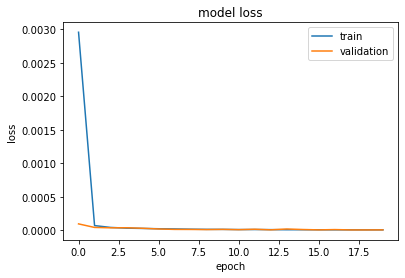

In [88]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [89]:
pred_model_3_y_test_std = model_3.predict(X_test_std)
pred_model_3_y_test = pred_model_3_y_test_std*(ymax-ymin) + ymin
pred_model_3_y_test.shape

(16290, 1)

In [90]:
rmse_lstm_3 = np.sqrt(mean_squared_error(y_test, pred_model_3_y_test))
print("RMSE of Stacked LSTM: ", rmse_lstm_3)
print("I.E. %.04f degree of mean error" % (rmse_lstm_3/math.pi*180))

RMSE of Stacked LSTM:  0.0050284348097072405
I.E. 0.2881 degree of mean error


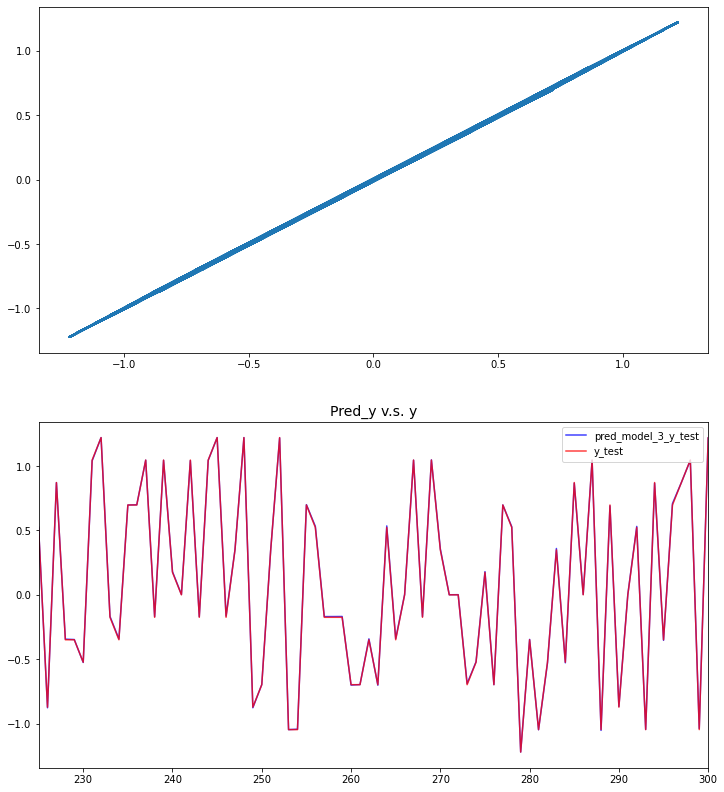

In [91]:
fig ,ax_lst = plt.subplots(2, 1,figsize=(12,14))
ax_lst[0].plot(pred_model_3_y_test, y_test)
ax_lst[1].plot([i for i in range(pred_model_3_y_test.shape[0])], list(pred_model_3_y_test), color='b', alpha=0.75, label='pred_model_3_y_test')
ax_lst[1].plot(y_test, color='red', alpha=0.75, label='y_test')
ax_lst[1].set_title(f"Pred_y v.s. y",fontsize=14)
ax_lst[1].grid(False)
ax_lst[1].legend(loc='upper right')
ax_lst[1].set_xlim([225, 300])
plt.show()

### LSTM-Autoencoder

In [95]:
time_steps = 3
feature_dim = 20

x0 = Input(shape=(time_steps, feature_dim))
l1 = LSTM(128, activation='relu', return_sequences=True)(x0)
l2 = LSTM(64, activation='relu', return_sequences=False)(l1)
h0 = RepeatVector(time_steps)(l2)
l3 = LSTM(64, activation='relu', return_sequences=True)(h0)
l4 = LSTM(128, activation='relu', return_sequences=True)(l3)
r0 = TimeDistributed(Dense(feature_dim))(l4)


LSTM_AE = Model(inputs=x0, outputs=r0)
LSTM_AE.compile(optimizer='adam', loss='mse')
LSTM_AE.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 128)            76288     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 64)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 3, 64)             33024     
_________________________________________________________________
lstm_17 (LSTM)               (None, 3, 128)            98816     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 20)             2580

In [96]:
epochs = 20
batch_size = 200

history_lstm_ae = LSTM_AE.fit(X_train_std, X_train_std, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_std, X_test_std))

Train on 65160 samples, validate on 16290 samples
Epoch 1/20
65160/65160 [==============================] - 4s 65us/step - loss: 0.0442 - val_loss: 0.0034
Epoch 2/20
65160/65160 [==============================] - 3s 51us/step - loss: 0.0024 - val_loss: 0.0016
Epoch 3/20
65160/65160 [==============================] - 3s 51us/step - loss: 0.0010 - val_loss: 7.5922e-04
Epoch 4/20
65160/65160 [==============================] - 3s 51us/step - loss: 6.0059e-04 - val_loss: 4.8832e-04
Epoch 5/20
65160/65160 [==============================] - 3s 52us/step - loss: 4.2473e-04 - val_loss: 3.5600e-04
Epoch 6/20
65160/65160 [==============================] - 3s 51us/step - loss: 3.3481e-04 - val_loss: 2.9450e-04
Epoch 7/20
65160/65160 [==============================] - 3s 52us/step - loss: 2.8455e-04 - val_loss: 2.6419e-04
Epoch 8/20
65160/65160 [==============================] - 3s 51us/step - loss: 2.5287e-04 - val_loss: 2.3225e-04
Epoch 9/20
65160/65160 [==============================] - 3s 53us/

In [97]:
pred_X_test_std = LSTM_AE.predict(X_test_std, verbose=0)
print('---Predicted---')
print(np.round(pred_X_test_std, 4))
print('---Actual---')
print(np.round(X_test_std, 4))

---Predicted---
[[[ 3.611e-01 -7.000e-04  3.699e-01 ...  6.941e-01  7.906e-01 -4.000e-04]
  [ 3.603e-01 -8.000e-04  3.647e-01 ...  6.930e-01  7.904e-01 -3.100e-03]
  [ 3.472e-01 -2.000e-04  3.572e-01 ...  6.916e-01  7.909e-01 -2.200e-03]]

 [[ 4.420e-01  5.000e-04  7.230e-02 ...  9.330e-02  9.898e-01  6.000e-04]
  [ 4.346e-01  5.000e-04  6.940e-02 ...  8.860e-02  9.767e-01 -1.000e-03]
  [ 4.315e-01 -1.100e-03  7.010e-02 ...  9.030e-02  9.752e-01  3.000e-04]]

 [[ 9.894e-01 -2.000e-04  8.315e-01 ...  2.979e-01  1.672e-01 -1.500e-03]
  [ 9.824e-01 -9.000e-04  8.284e-01 ...  2.963e-01  1.630e-01 -2.200e-03]
  [ 9.821e-01 -1.600e-03  8.293e-01 ...  2.972e-01  1.600e-01 -2.200e-03]]

 ...

 [[ 3.660e-01  3.000e-04  3.721e-01 ...  6.683e-01  7.913e-01  3.000e-04]
  [ 3.437e-01 -1.000e-04  3.468e-01 ...  6.583e-01  7.714e-01 -2.400e-03]
  [ 3.080e-01 -4.000e-04  3.139e-01 ...  6.293e-01  7.124e-01 -1.900e-03]]

 [[ 9.515e-01 -1.300e-03  7.002e-01 ...  3.110e-01  2.298e-01  1.000e-04]
  [ 9.55

In [98]:
encoder = Model(inputs=x0, outputs=l2)
encoder.compile(optimizer='adam', loss='mse')
encoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3, 20)             0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 128)            76288     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                49408     
Total params: 125,696
Trainable params: 125,696
Non-trainable params: 0
_________________________________________________________________


In [99]:
# Predict both Train/Test data for further training the Regressor
pred_encoded_X_train_std = encoder.predict(X_train_std)
pred_encoded_X_test_std = encoder.predict(X_test_std)
pred_encoded_X_test_std.shape

(16290, 64)

### Dense-regressor on Encoded R-features

In [103]:
def build_regressor():
    feature_dim = 64
    
    x = Input(shape=(feature_dim,))
    h1 = Dense(32, activation='relu')(x)
    h2 = Dense(32, activation='relu')(h1)
    h3 = Dense(8, activation='relu')(h2)
    r = Dense(1, activation='linear')(h3)
    
    return Model(inputs=x, outputs=r)

model_4 = build_regressor()
model_4.compile(optimizer='adam', loss='mse')
model_4.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 9         
Total params: 3,409
Trainable params: 3,409
Non-trainable params: 0
_________________________________________________________________


In [104]:
epochs = 30
batch_size = 100

history_model_4 = model_4.fit(pred_encoded_X_train_std, y_train_std, batch_size=batch_size, epochs=epochs, \
                    verbose=1, validation_data=(pred_encoded_X_test_std, y_test_std))

Train on 65160 samples, validate on 16290 samples
Epoch 1/30
65160/65160 [==============================] - 2s 24us/step - loss: 0.0030 - val_loss: 8.9471e-04
Epoch 2/30
65160/65160 [==============================] - 1s 19us/step - loss: 6.0242e-04 - val_loss: 4.4414e-04
Epoch 3/30
65160/65160 [==============================] - 1s 17us/step - loss: 4.2588e-04 - val_loss: 3.3163e-04
Epoch 4/30
65160/65160 [==============================] - 1s 17us/step - loss: 3.2540e-04 - val_loss: 2.3995e-04
Epoch 5/30
65160/65160 [==============================] - 1s 17us/step - loss: 2.7070e-04 - val_loss: 1.7146e-04
Epoch 6/30
65160/65160 [==============================] - 1s 19us/step - loss: 2.1739e-04 - val_loss: 1.9035e-04
Epoch 7/30
65160/65160 [==============================] - 1s 18us/step - loss: 2.0646e-04 - val_loss: 1.7352e-04
Epoch 8/30
65160/65160 [==============================] - 1s 19us/step - loss: 1.7320e-04 - val_loss: 1.6925e-04
Epoch 9/30
65160/65160 [==========================

In [105]:
pred_model_4_y_test_std = model_4.predict(pred_encoded_X_test_std)
pred_model_4_y_test = pred_model_4_y_test_std*(ymax-ymin) + ymin

rmse_model_4 = np.sqrt(mean_squared_error(y_test, pred_model_4_y_test))
print("RMSE of LSTM-AE + 4FC: ", rmse_model_4)
print("I.E. %.04f degree of mean error" % (rmse_model_4/math.pi*180))

RMSE of LSTM-AE + 4FC:  0.01824756751970544
I.E. 1.0455 degree of mean error


### SVR on Encoded R-features

In [106]:
# SVR
svr_ae = SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.01)
svr_ae.fit(pred_encoded_X_train_std, y_train)
svr_ae.score(pred_encoded_X_test_std, y_test)

0.999608784337431

In [75]:
'''
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
grid = GridSearchCV(svr_3,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)
grid.fit(pred_encoded_X_train_std, y_train)
print(grid.best_estimator_)
print(grid.best_score_)
'''

"\nparams = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}\ngrid = GridSearchCV(svr_3,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)\ngrid.fit(pred_encoded_X_train_std, y_train)\nprint(grid.best_estimator_)\nprint(grid.best_score_)\n"

In [107]:
pred_EncodeSVR_y_test = svr_ae.predict(pred_encoded_X_test_std)
rmse_svr_ae = np.sqrt(mean_squared_error(y_test, pred_EncodeSVR_y_test))
print("RMSE for LSTM-AE + SVR:", rmse_svr_ae)
print("I.E. %.04f degree of mean error" % (rmse_svr_ae/math.pi*180))

RMSE for LSTM-AE + SVR: 0.014725825148479732
I.E. 0.8437 degree of mean error


In [108]:
len(y_test)

16290

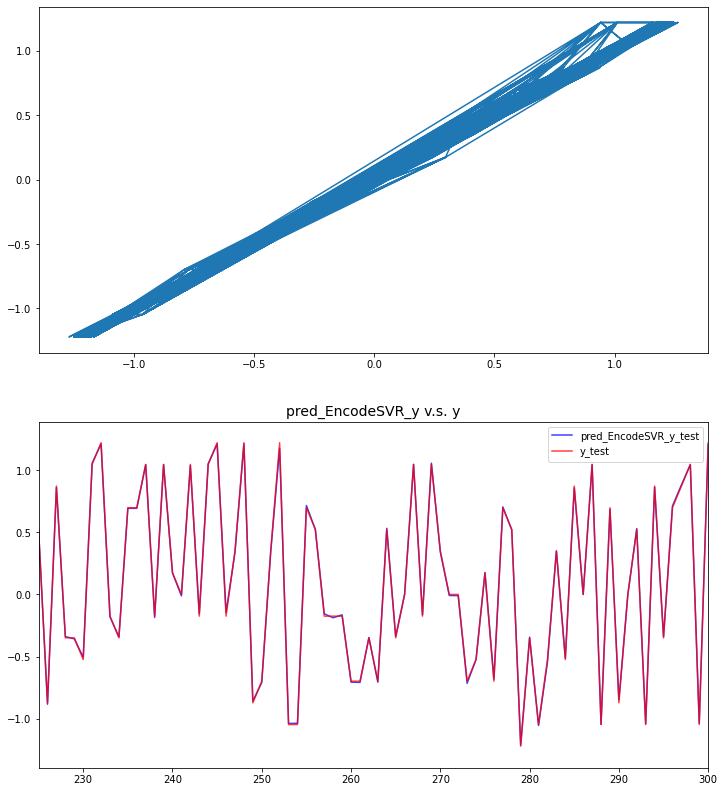

In [109]:
fig ,ax_lst = plt.subplots(2, 1,figsize=(12,14))
ax_lst[0].plot(pred_EncodeSVR_y_test, y_test)
ax_lst[1].plot([i for i in range(pred_EncodeSVR_y_test.shape[0])], list(pred_EncodeSVR_y_test), color='b', alpha=0.75, label='pred_EncodeSVR_y_test')
ax_lst[1].plot(y_test, color='red', alpha=0.75, label='y_test')
ax_lst[1].set_title(f"pred_EncodeSVR_y v.s. y",fontsize=14)
ax_lst[1].grid(False)
ax_lst[1].legend(loc='best')
ax_lst[1].set_xlim([225, 300])
plt.show()

### Visualize CDF

In [110]:
y_err_series = pd.Series(abs(y_test - pred_EncodeSVR_y_test) / math.pi*180)

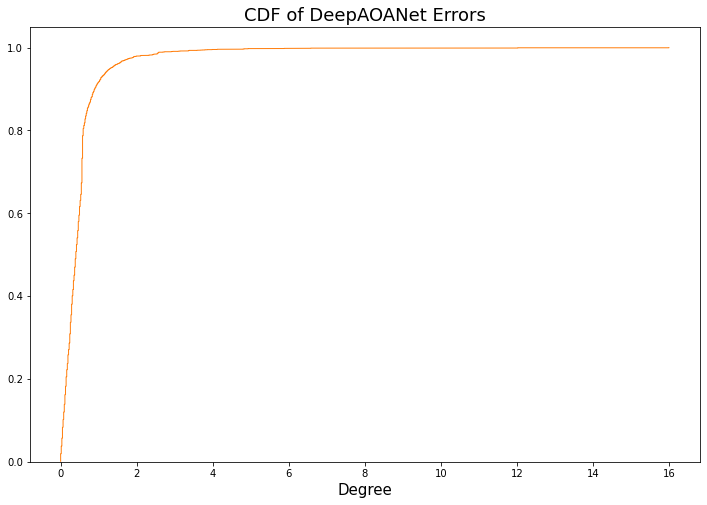

In [111]:
fig_hist, ax_hist = plt.subplots(1,1, figsize=(12,8))
n, bins, patches = ax_hist.hist(y_err_series, density=True, cumulative = True, histtype='step', bins=1000, color='tab:orange')
patches[0].set_xy(patches[0].get_xy()[:-1])
ax_hist.set_title("CDF of DeepAOANet Errors", fontsize=18)
ax_hist.set_xlabel("Degree", fontsize=15)
plt.show()

### Directly apply SVR on Rjk (Optional)

In [82]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(Xvec, yvec, test_size=0.2, random_state=42)

In [83]:
svr_0 = SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.01)
svr_0.fit(X_train0, y_train0)
svr_0.score(X_test0, y_test0)

0.9780749041620128

In [84]:
pred_SVR0_y_test = svr_0.predict(X_test0)
rmse0 = np.sqrt(mean_squared_error(y_test0, pred_SVR0_y_test))
print("RMSE for SVR0:", rmse0)
print("I.E. %.04f degree of mean error" % (rmse0/math.pi*180))

RMSE for SVR0: 0.11185163990608234
I.E. 6.4086 degree of mean error


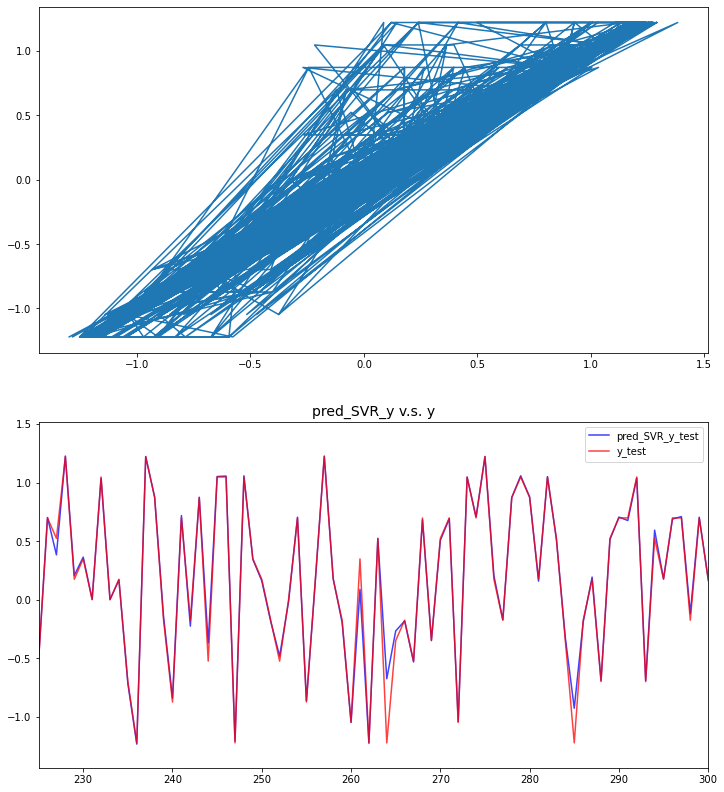

In [85]:
fig0 ,ax_lst0 = plt.subplots(2, 1,figsize=(12,14))
ax_lst0[0].plot(pred_SVR0_y_test, y_test0)
ax_lst0[1].plot([i for i in range(pred_SVR0_y_test.shape[0])], list(pred_SVR0_y_test), color='b', alpha=0.75, label='pred_SVR_y_test')
ax_lst0[1].plot(y_test0, color='red', alpha=0.75, label='y_test')
ax_lst0[1].set_title(f"pred_SVR_y v.s. y",fontsize=14)
ax_lst0[1].grid(False)
ax_lst0[1].legend(loc='best')
ax_lst0[1].set_xlim([225, 300])
plt.show()

# CDF

In [112]:
y_err_music_series = pd.Series(abs(y_test[i] / math.pi*180 - y_test_music[i]) for i in range(len(y_test)))

In [114]:
y_err_lstm_ae_svr_series = pd.Series(abs(y_test - pred_EncodeSVR_y_test) / math.pi*180)

In [115]:
y_err_lstm_ae_fc_series = pd.Series(abs(y_test - pred_model_4_y_test.ravel()) / math.pi*180)

In [116]:
y_err_lstm_3_series = pd.Series(abs(y_test - pred_model_3_y_test.ravel()) / math.pi*180)

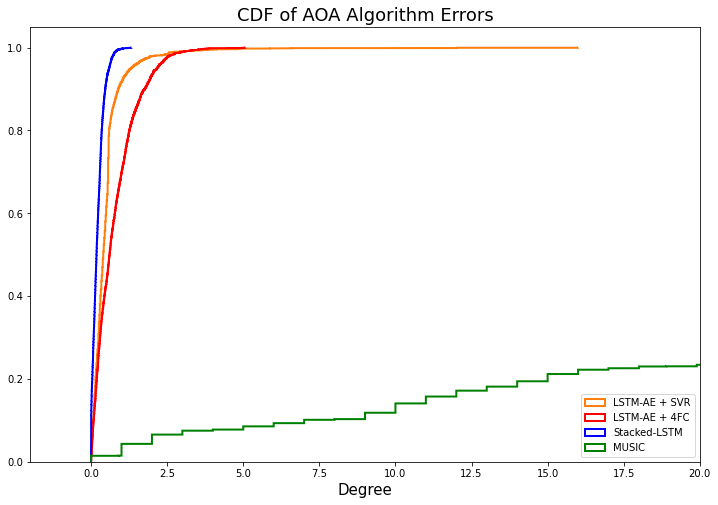

In [117]:
%matplotlib inline
fig_hist, ax_hist = plt.subplots(1,1, figsize=(12,8))

n, bins, patches = ax_hist.hist(y_err_lstm_ae_svr_series, density=True, cumulative = True, histtype='step', \
                                bins=1000, color='tab:orange', linewidth=2, label='LSTM-AE + SVR')
patches[0].set_xy(patches[0].get_xy()[:-1])
n2, bins2, patches2 = ax_hist.hist(y_err_lstm_ae_fc_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='red', linewidth=2, label='LSTM-AE + 4FC')
patches2[0].set_xy(patches2[0].get_xy()[:-1])
n3, bins3, patches3 = ax_hist.hist(y_err_lstm_3_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='b', linewidth=2, label='Stacked-LSTM')
patches3[0].set_xy(patches3[0].get_xy()[:-1])
n4, bins4, patches4 = ax_hist.hist(y_err_music_series, density=True, cumulative = True, histtype='step', \
                                   bins=1000, color='g', linewidth=2, label='MUSIC')
patches4[0].set_xy(patches4[0].get_xy()[:-1])

ax_hist.set_title("CDF of AOA Algorithm Errors", fontsize=18)
ax_hist.set_xlabel("Degree", fontsize=15)
ax_hist.set_xlim(-2, 20)
ax_hist.legend(loc='lower right')

fig_hist.savefig(join(load_dir, 'CDF3.png'), facecolor="w", bbox_inches='tight')
plt.show()

## Validation on Unseen Data

In [120]:
test_dict = {}
test_dir = join('data_1606', 'test')

for filename in os.listdir(test_dir):
    if filename.startswith("test_m") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        test_dict[- float(filename[6:-4])] = aoa_Rjk
    elif filename.startswith("test_") and filename.endswith(".csv"):
        aoa = pd.read_csv(join(test_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[fields_lst]
        test_dict[float(filename[5:-4])] = aoa_Rjk

In [121]:
test_sig = {}
test_sig_index = {}

for key in test_dict.keys():
    test_dict[key]['theta'] = key * math.pi / 180
    test_sig_index[key] = (test_dict[key][abs(test_dict[key]['field.data2']) < field_thres].index)
    test_sig[key] = test_dict[key].iloc[test_sig_index[key], :]

Xtest = pd.concat([test_sig[rad] for rad in test_dict.keys()], \
                 keys=[rad for rad in test_dict.keys()], names=['Series name', 'Row ID'])
Xtest['music'] = pd.Series([0] * len(Xtest.index))

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [122]:
Xtest_arr, ytest_lst2, Xtest_vec, ytest_vec = Split_TimeSeries3(Xtest, aoa_gt_series=range(-45, 90, 45))

In [123]:
X_train_null, X_test2, y_train_null, y_test2 = train_test_split(Xtest_arr, ytest_lst2, test_size=0.9, random_state=42)

In [124]:
# Normalization
X_test2_std = mmsc.transform(X_test2.reshape(-1, X_test2.shape[-1])).reshape(X_test2.shape)

y_test2_lst = [item[0] for item in y_test2]
y_test2_lst_std = (y_test2_lst - ymin)/(ymax-ymin)

In [126]:
# Stacked LSTM
pred_X_test2_std = model_3.predict(X_test2_std)
pred_X_test2 = pred_X_test2_std*(ymax - ymin) + ymin

pred_X_test2_std.shape

(2655, 1)

In [127]:
rmse_lstm2 = np.sqrt(mean_squared_error(y_test2_lst, pred_X_test2_std))
print("RMSE of LSTM-only: ", rmse_lstm2)
print("I.E. %.04f degree of mean error" % (rmse_lstm2/math.pi*180))

RMSE of LSTM-only:  0.6488807936803935
I.E. 37.1781 degree of mean error


In [129]:
# Encoder-SVR
pred_EncoderSVR_ytest_lst = svr_ae.predict(encoder.predict(X_test2_std))

rmse_EncoderSVR = np.sqrt(mean_squared_error(y_test2_lst, pred_EncoderSVR_ytest_lst))
print("RMSE of LSTM-Encoder + SVR: ", rmse_EncoderSVR)
print("I.E. %.04f degree of mean error" % (rmse_EncoderSVR/math.pi*180))

RMSE of LSTM-Encoder + SVR:  1.4139396519229863
I.E. 81.0128 degree of mean error


In [165]:
# DirectSVR
X_train_null, X_test2vec, y_train_null, y_test2vec = train_test_split(Xtest_vec, ytest_vec, test_size=0.9, random_state=42)
pred_SVR_y_test2vec2 = svr_0.predict(X_test2vec)
rmse_svronly2 = np.sqrt(mean_squared_error(y_test2vec, pred_SVR_y_test2vec2))
print("RMSE for SVR-Only:", rmse_svronly2)
print("I.E. %.04f degree of mean error" % (rmse_svronly2/math.pi*180))

RMSE for SVR-Only: 0.8498518628498417
I.E. 48.6929 degree of mean error
